In [ ]:
# default_exp inferno

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Interpolation INFERNO loss

Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
Runs and reproduces some of the paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
from pytorch_inferno.inference import calc_nll

from fastcore.all import partialler
from typing import Tuple

In [ ]:
from fastcore.all import partialler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
import numpy as np
from abc import abstractmethod
from typing import  Optional, List
from fastcore.all import store_attr, delegates

import torch.nn.functional as F
from torch import optim, autograd
from torch.distributions import Normal
from torch import Tensor
import torch
import torch.nn as nn
from torch.distributions import Distribution

from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

# Loss

Class initialised with a true number of signal events $\mu$ and a true number of events $n$. The true number of background events is then computed as $n-mu$. The number of nuisance parameters must also be passed.

This process only approximates the effect of shape systematics, since they are evaluated as up/down shape variations and the inter-dependence of them is not accounted for. It is, however, perhaps more realistic/practical, since the exact effect of the nuisances on the input features do not have to be analytically derivable, instead one can use up/down Monte Carlo samples. For this synthetic example, the analytical effects are used.

Running cycle is:
1. for e in #epochs:
    1. for b in #batches:
        1. on_forwards_end:
            1. compute up/down shape variations by augmenting data and passing through model
            1. set alpha as tensor with gradient and `n_alpha+1` elements. Set element zero to $\mu$
            1. compute the full hessian of the negative log-likelihood w.r.t alpha (shape systematics included by running model augmented data to get up/down shapes)
            1. invert hessian and set the diagonal element corresponding to $\mu$ as the loss value

In [ ]:
# export
class AbsApproxInferno(AbsInferno):
    r'''Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
    Includes option to randomise params per batch and converge to better values, which results in slightly better performance'''
    @delegates(AbsInferno)
    def __init__(self, aug_alpha:bool=False, n_steps:int=100, lr:float=0.1, **kwargs):
        super().__init__(**kwargs)
        store_attr('aug_alpha, n_steps, lr')
    
    def _aug_data(self): pass  # Override abs method
    def on_batch_begin(self) -> None: pass
    def on_batch_end(self) -> None: pass
    
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @abstractmethod
    def _get_up_down(self, x_s:Tensor, x_b:Tensor) -> Tuple[Tuple[Optional[Tensor],Optional[Tensor]],Tuple[Optional[Tensor],Optional[Tensor]]]:
        r'''Compute upd/down shapes for signal and background seperately. Overide this for specific problem.'''
        pass
    
    def get_ikk(self, f_s_nom:Tensor, f_b_nom:Tensor, f_s_up:Optional[Tensor], f_s_dw:Optional[Tensor], f_b_up:Optional[Tensor], f_b_dw:Optional[Tensor]) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        if self.aug_alpha: alpha = torch.randn((self.n_alpha), requires_grad=True, device=self.wrapper.device)/10
        else:              alpha = torch.zeros((self.n_alpha), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[self.poi_idx] += self.mu_true
        get_nll = partialler(calc_nll, s_true=self.mu_true, b_true=self.b_true,
                             f_s_nom=f_s_nom, f_b_nom=f_b_nom, f_s_up=f_s_up, f_s_dw=f_s_dw,
                             f_b_up=f_b_up, f_b_dw=f_b_dw, shape_aux=self.shape_aux, s_norm_aux=self.s_norm_aux, b_norm_aux=self.b_norm_aux)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(mu=alpha[self.poi_idx], s_norm_alpha=alpha[self.s_norm_idxs], b_norm_alpha=alpha[self.b_norm_idxs], shape_alpha=alpha[self.shape_idxs])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(mu=alpha[self.poi_idx], s_norm_alpha=alpha[self.s_norm_idxs], b_norm_alpha=alpha[self.b_norm_idxs], shape_alpha=alpha[self.shape_idxs])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        return torch.inverse(h)[self.poi_idx,self.poi_idx]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        b = self.wrapper.y.squeeze() == 0
        f_s = self.to_shape(self.wrapper.y_pred[~b])
        f_b = self.to_shape(self.wrapper.y_pred[b])
        (f_s_up,f_s_dw),(f_b_up,f_b_dw)= self._get_up_down(self.wrapper.x[~b], self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s_nom=f_s, f_b_nom=f_b, f_s_up=f_s_up, f_s_dw=f_s_dw, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [ ]:
# export
class ApproxPaperInferno(AbsApproxInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    @delegates(AbsApproxInferno, but=['b_shape_alpha', 's_shape_alpha'])
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 b_true:float=1000, mu_true:float=50, **kwargs):
        super().__init__(b_true=b_true, mu_true=mu_true, n_shape_alphas=(r_mods is not None)+(l_mods is not None), b_shape_alpha=True, **kwargs)
        store_attr('r_mods, l_mods, l_init')
        
    def on_train_begin(self) -> None:
        super().on_train_begin()
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x_s:Tensor, x_b:Tensor) -> Tuple[Tuple[Optional[Tensor],Optional[Tensor]],Tuple[Optional[Tensor],Optional[Tensor]]]:
        if self.r_mods is None and self.l_mods is None: return (None,None),(None,None)
        u,d = [],[]
        if self.r_mods is not None:
            with torch.no_grad(): x_b = x_b+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x_b)))
            with torch.no_grad(): x_b = x_b+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x_b)))
            with torch.no_grad(): x_b = x_b-self.r_mod_t[1]
        if self.l_mods is not None:
            with torch.no_grad(): x_b = x_b*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x_b)))
            with torch.no_grad(): x_b = x_b*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x_b)))
            with torch.no_grad(): x_b = x_b/self.l_mod_t[1]
        return (None,None),(torch.stack(u),torch.stack(d))

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(1, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
          cbs=[ApproxPaperInferno(r_mods=(-0.2,0.2), l_mods=(2.5,3.5), shape_aux=[Normal(0,2), Normal(0,2)], nonaux_b_norm=True, b_norm_aux=[Normal(0,100)], aug_alpha=False, n_steps=10),
               LossTracker(),SaveBest('weights/best_ii.h5'),EarlyStopping(2)])

1: Train=2040.1375436401368 Valid=690.299853515625
Loading best model with loss 690.299853515625
CPU times: user 11.5 s, sys: 1.65 s, total: 13.2 s
Wall time: 12 s


In [ ]:
model.save('weights/Inferno_Test_interp_bm2.h5')

[autoreload of pytorch_inferno.data failed: Traceback (most recent call last):
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 288, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/Users/giles/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 288, in update_class
    if update_generic(old_obj, new_obj)

In [ ]:
model.load('weights/Inferno_Test_interp_bm2.h5')

# Results

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,5,1.0
1,7,1.0
2,5,1.0
3,5,1.0
4,5,1.0


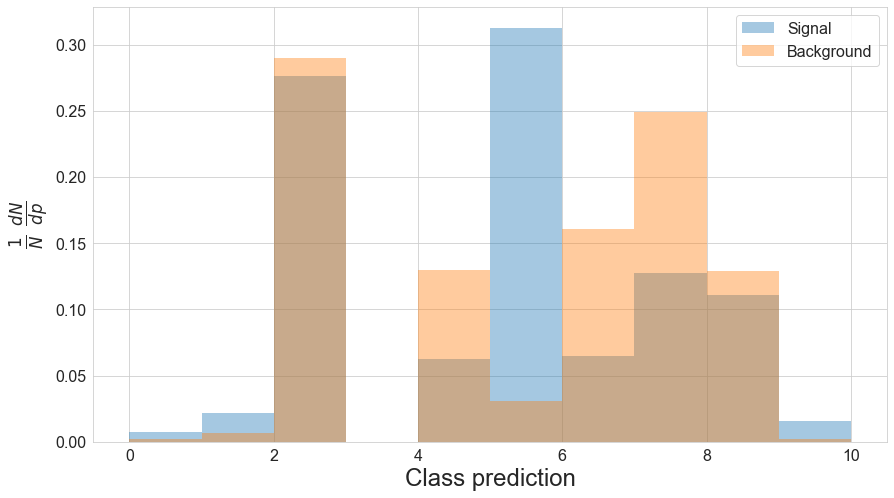

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,5,1.0,5
1,7,1.0,7
2,5,1.0,5
3,5,1.0,5
4,5,1.0,5


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
n = 1050
mu_scan = torch.linspace(20,80,61)

In [ ]:
profiler = partialler(calc_profile, f_s_nom=f_s, f_b_nom=f_b, n_obs=1050, mu_scan=mu_scan, mu_true=50, n_steps=100)

In [ ]:
nll = profiler()

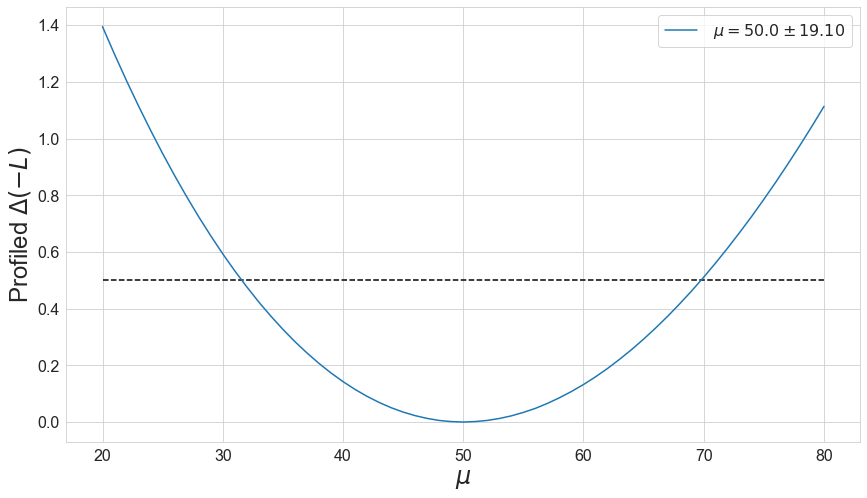

[19.098483749233175]

In [ ]:
plot_likelihood(nll, mu_scan=mu_scan)

# Nuisances

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,5,1.0,5,5,5,5,5,5,5,5,5,5,5
1,7,1.0,7,7,7,7,7,7,7,7,7,7,7
2,5,1.0,5,5,5,5,5,5,5,5,5,5,5
3,5,1.0,5,5,5,5,5,5,5,5,5,5,5
4,5,1.0,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,7,0.0,7,7,7,7,7,7,7,7,7,7,7
999996,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999997,4,0.0,4,4,4,4,4,4,4,4,4,4,4
999998,2,0.0,2,2,2,2,2,2,2,2,2,2,2


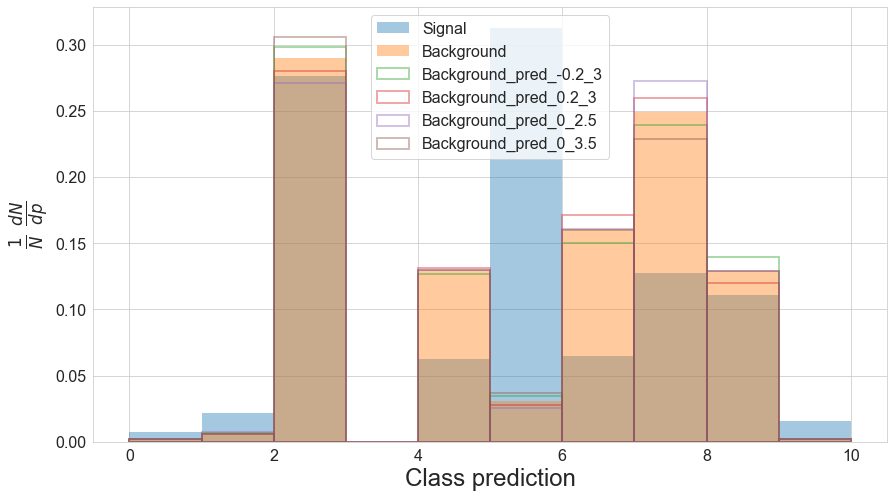

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

# Newton

## BM 1
r free, l fixed

In [ ]:
nll = profiler(f_b_up=b_shapes['f_b_up'][0], f_b_dw=b_shapes['f_b_dw'][0])

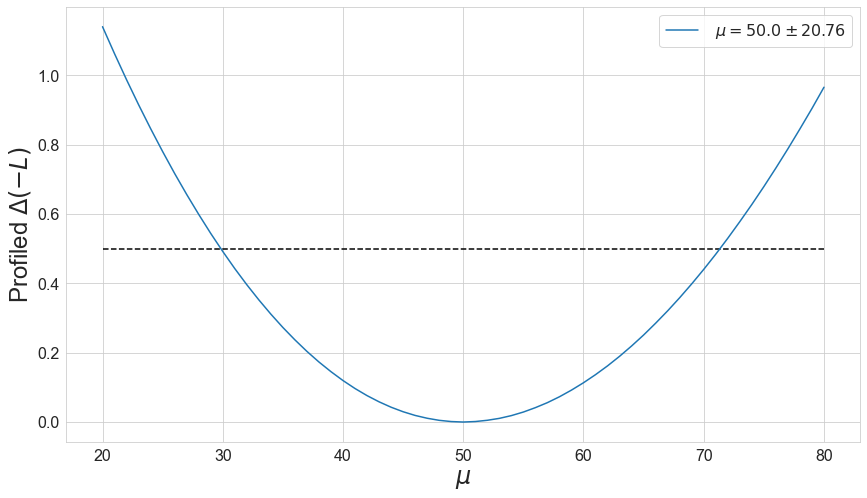

[20.755227139465823]

In [ ]:
plot_likelihood(nll, mu_scan)

## BM 1l
r fixed, l free

In [ ]:
nll = profiler(f_b_up= b_shapes['f_b_up'][1], f_b_dw=b_shapes['f_b_dw'][1])

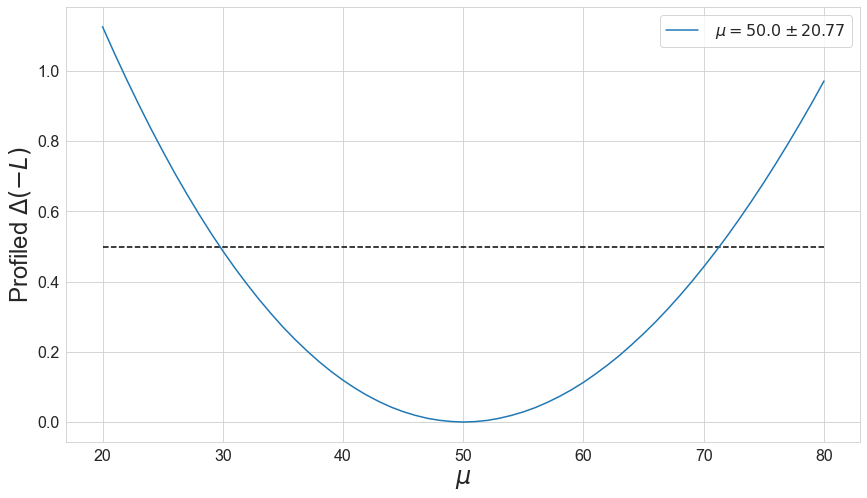

[20.773284157170224]

In [ ]:
plot_likelihood(nll, mu_scan)

## BM 2

In [ ]:
nll = profiler(**b_shapes)

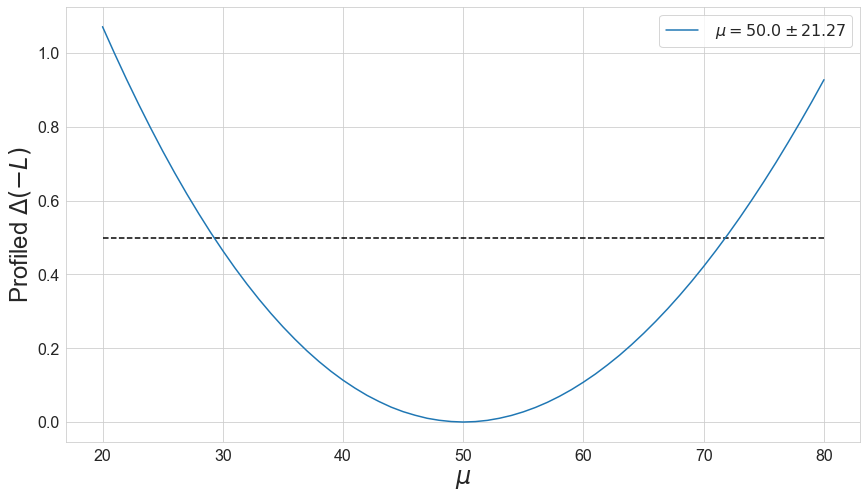

[21.274396215186457]

In [ ]:
plot_likelihood(nll, mu_scan)

In [ ]:
b_shapes

OrderedDict([('f_b_nom',
              tensor([[2.0900e-03, 6.3720e-03, 2.8979e-01, 2.0000e-13, 1.2954e-01, 3.0890e-02,
                       1.6091e-01, 2.4900e-01, 1.2940e-01, 2.0060e-03]])),
             ('f_b_up',
              tensor([[1.7560e-03, 5.8640e-03, 2.8042e-01, 2.0000e-13, 1.3159e-01, 2.7676e-02,
                       1.7119e-01, 2.5996e-01, 1.1977e-01, 1.7760e-03],
                      [1.8500e-03, 5.5920e-03, 3.0597e-01, 2.0000e-13, 1.2943e-01, 3.6628e-02,
                       1.6034e-01, 2.2894e-01, 1.2928e-01, 1.9580e-03]])),
             ('f_b_dw',
              tensor([[2.3580e-03, 6.5600e-03, 2.9837e-01, 2.0000e-13, 1.2661e-01, 3.4386e-02,
                       1.5052e-01, 2.3961e-01, 1.3933e-01, 2.2480e-03],
                      [2.4460e-03, 7.3080e-03, 2.7112e-01, 2.0000e-13, 1.2962e-01, 2.5366e-02,
                       1.6082e-01, 2.7221e-01, 1.2908e-01, 2.0360e-03]]))])

In [ ]:
f_s

tensor([[7.4520e-03, 2.1856e-02, 2.7604e-01, 2.0000e-13, 6.2560e-02, 3.1289e-01,
         6.5100e-02, 1.2767e-01, 1.1074e-01, 1.5700e-02]])

## BM 3

In [ ]:
shape_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(shape_aux=shape_aux, **b_shapes)

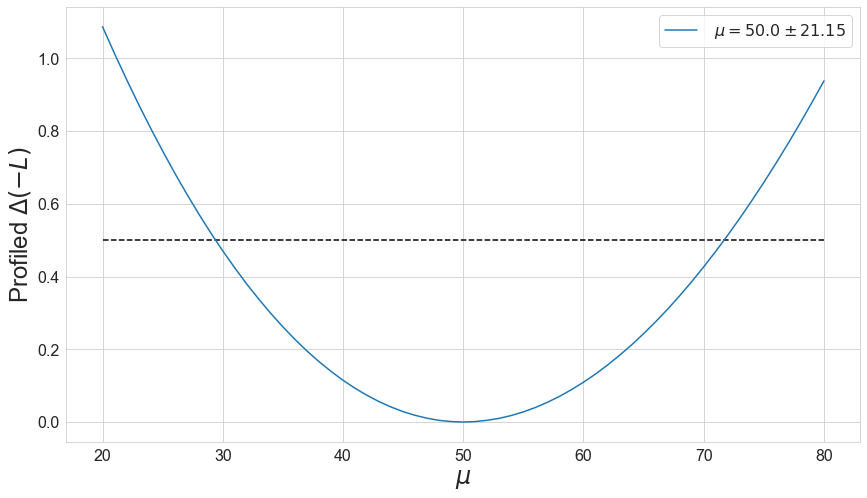

[21.146971175475567]

In [ ]:
plot_likelihood(nll, mu_scan)

## BM 4

In [ ]:
nll = profiler(shape_aux=shape_aux, b_norm_aux=[Normal(0,100)], **b_shapes)

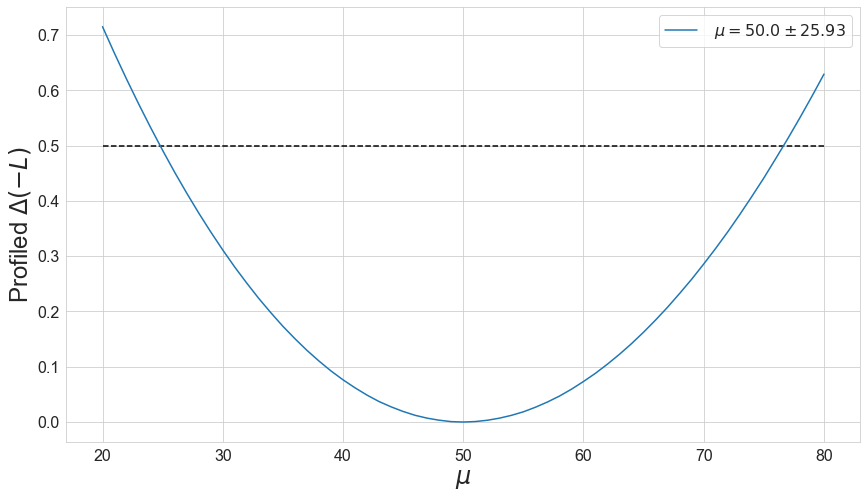

[25.930942296161362]

In [ ]:
plot_likelihood(nll, mu_scan)